# Solving household problems in macroeconomics and finance

In this unit, we explore how to solve simple consumption-savings problems
that are common in (heterogeneous-agent) macroeconomics and household finance.

For simplicity, we study infinite-horizon problems even though
life-cycle models with finitely-lived agents are becoming more common
in macroeconomics and are almost universal in household finance.
The implementation is almost identical in both cases, with the major difference
being that

1. Infinite-horizon problems are solved by iteration until convergence
    (of the value or policy functions) starting from some initial guess.
2. Life-cycle problems are solved by backward induction, starting from the
    terminal period $T$ and iterating backwards through periods
    $T-1$, $T-2$, etc. until the first period.

Throughout this unit, we will exclusively solve partial equilibrium
problems for given prices (interest rates and wages). Solving for general
equilibrium would require us to find an additional fixed point in terms
of equilibrium prices (in steady-state models such as Aiyagari (1994)
or Huggett (1993)), or a equilibrium forecasting rule
(for models with aggregate uncertainty such as Krusell-Smith (1998)).

For numerical purposes it is necessary to formulate the household
problem in recursive form. You may be more familiar with the sequential
formulation of an infinite horizon problem which could look something like
the following,
$$
\begin{aligned}
V(a_0) &= \max_{(c_t,\,a_{t+1})_{t=0}^{\infty}}
\sum_{t=0}^{\infty} \beta^t u(c_t)  \\
\text{s.t.} \quad & c_t + a_{t+1} = (1+r)a_t + y_t \quad \forall~t \\
& c_t \geq 0,\; a_{t+1} \geq 0 \quad \forall~t
\end{aligned}
$$
where the household chooses *sequences* of consumption $(c_t)_{t=0}^{\infty}$
and asset levels $(a_{t+1})_{t=0}^{\infty}$ for some initial assets $a_0$.
The value function $V$ is the maximum over such sequences.
However, when we solve a problem numerically on the computer, it is usually
more convenient to reformulate it recursively to obtain
$$
\begin{aligned}
V(a) = &\max_{c,\,a'}~\Bigl\{ u(c)
    + \beta V(a') \Bigr\} \\
    \text{s.t.} \quad &c + a' = (1+r)a  + y \\
    & c \geq 0,\; a' \geq 0
\end{aligned}
$$
where the household picks optimal *scalars* $c$ and $a'$ for given $a$
and parameters. 

*Note:* With recursive formulations we often use primes to denote
next-period values such as $a'$ instead of writing $t+1$ since time $t$
does not play any explicit role.

***

## VFI with deterministic income

### Household problem

For starters, consider the following *deterministic* infinite-horizon 
consumption-savings problem,
$$
\begin{aligned}
V(a) = &\max_{c,\,a'} \left\{ 
    \frac{c^{1-\gamma} - 1}{1-\gamma}
    + \beta V(a') \right\} \\
    \text{s.t.} \quad &c + a' = (1+r)a  + y \\
    &c \geq 0,\; a' \geq 0
\end{aligned}
$$
where $a$ are beginning-of-period assets, and $r$ and $y$ are the
interest rate and labour earnings, respectively, which are both
exogenous. The household has CRRA utility and chooses optimal consumption
$c$ and next-period assets $a'$ which are required to be non-negative
(i.e. we impose a borrowing constraint at 0).

Note that from a programming perspective we are interested in the case when
$y > 0$ as otherwise this problem can be solved analytically (the household
consumes a constant fraction of its assets due to CRRA preferences).

For $y > 0$, this problem has to be solved numerically which we do using
*value function iteration (VFI)*. VFI takes an initial guess $V_0$ and
solves the above problem repeatedly, generating a sequence of updated guesses
$V_n, V_{n+1}, \dots$. We terminate the algorithm once consecutive $V_n$
do not change anymore.

VFI itself does not dictate how the updated $V$ is computed. In the sections below we explore two alternatives:

1. VFI combined with grid search; and
2. VFI combined with interpolation;

### VFI with grid search

The simplest way to solve the above problem is to use the so-called
*grid search* algorithm  where we try all candidate savings levels
from a discrete set of choices (the *grid*). Instead of picking
an arbitrary $a' \in [0, (1+r)a + y]$, the household is thus constrained
to pick an element $a' \in \Gamma_{a}$ from the pre-determined 
set of $N_a$ feasible asset levels
$$
\Gamma_{a} = \Bigl\{a_1, a_1, a_2, \dots, a_{N_a} \Bigr\}
$$
For convenience, we often use the grid $\Gamma_a$ both as the set of 
points for which we solve the problem numerically as well as the 
household's choice set for $a'$, thus forcing the household to pick 
a point on the grid on which the problem is defined. This is not strictly
required (the household could in principle choose from an arbitrary
finite set), but allows us to skip any interpolation of the continuation value
function $V(a')$.

While grid search is generally considered obsolete in modern applications,
it has a few distinct advantages:

1. Easy to implement;
2. Does not require computing derivatives (even more, it does not assume
    differentiability);
3. Fast (unless the grid is very dense or there are many choices);

However, we usually avoid it because of its disadvantages:

1. It's imprecise, and policy function are often not smooth (unless
    the grid is very dense);
2. Does not scale well to multiple choice dimensions;

You might still have to resort to grid search if your problem is not 
differentiable or has local maxima which breaks more sophisticated solution methods.

#### Outline of the algorithm

The grid search algorithm for this problem can be summarized as follows:

1. Create an asset grid $\Gamma_a = (a_1, \dots, a_{N_a}).$
2. Pick an initial guess $V_0$ for the value function defined on $\Gamma_a$.
3. In iteration $n$, perform the following steps:

    For each asset level $a_i$ at grid point $i$,
      1. Find all feasible next-period
        asset levels $a_j \in \Gamma_a$ that satisfy the
        budget constraint, $$a_j \leq (1+r)a_i + y$$ 
      2. For each $j$, compute consumption: 
         $$c_j = (1+r)a_i + y - a_j$$
      3. For each $j$, compute utility: 
         $$U_j = u(c_j) + \beta V_n(a_j)$$
      4. Find the index $k$ that maximises the above expression:
         $$k = \arg\max_{j} \Bigl\{ u(c_j) + \beta V_n(a_j)\Bigr\}$$
      5. Set $V_{n+1,i} = U_k$ and store $k$ as the optimal choice at $i$.
4. Check for convergence: If $\|V_n-V_{n+1}\| < \epsilon$, 
  for some small tolerance $\epsilon > 0$, exit the algorithm.

We implement this algorithm below. For this level of complexity, we would
normally want to store the code as regular Python files (`*.py`) as opposed
to writing down the problem in a Jupyter notebook. The complete implementation
is therefore available in the files 

- [`lectures/unit11/main.py`](../lectures/unit11/main.py): sets up the problem, calls the VFI solver, plots results; and 
- [`lectures/unit11/VFI.py`](../lectures/unit11/VFI.py): implements VFI with grid search as well as with interpolation;

The sections below walk you through this implementation in notebook format.

#### Defining parameters and grids

For our implementation, we use the following parameters which are standard
in macroeconomics:

| Parameter | Description | Value |
|-----------|-------------|-------|
| $\beta$ | Discount factor | 0.96 |
| $\gamma$ | Coef. of relative risk aversion | 2 |
| $r$ | Interest rate | 0.04 |
| $y$ | Labour income | 1 |

In Python, it is convenient to store all these parameters in a single
object so we don't have to pass numerous arguments to functions that
perform the actual computations. To this end, we define a class 
which serves as a container object:

In [1]:
from dataclasses import dataclass

@dataclass
class Parameters:
    """
    Define object to store model parameters and their default values
    """
    beta = 0.96         # Discount factor
    gamma = 1.0         # Risk aversion
    y = 1.0             # Labour income
    r = 0.04            # Interest rate
    grid_a = None       # Asset grid (to be created)

The `@dataclass` decorator is a convenient short-hand to define the attributes
directly within the class body (we can safely ignore the technical details).

*Note:* Once our code becomes more complex, it is good practice to
document the purpose of a `class` or function using the triple-quote
doc strings `""" ... """`. These are ignored by the Python interpreter.

We use this class definition to create a `Parameters` instance named `par` below. Additionally, we create the asset grid `grid_a` which we add to this object:

In [2]:
import numpy as np

par = Parameters()

# Start + end point for asset grid
a_min = 0.0
a_max = 10.0
# Number of grid points
N_a = 30

# Create asset grid with more points at the beginning
grid_a  = a_min + (a_max - a_min) * np.linspace(0.0, 1.0, N_a)**1.5

# Store asset grid in Parameters object
par.grid_a = grid_a

Note the seemingly unconventional way to create the asset grid where we 
first create a uniform grid on $[0, 1]$ and then compress the grid at lower
asset levels using an exponential transformation.

Alternatively, we could have created the usual uniformly-spaced grid:

In [3]:
grid_a_uniform = np.linspace(a_min, a_max, N_a)

However, we know from experience that the value and policy functions tend
to be nonlinear for low assets, and therefore it is advantageous to put more
grid points in that region.

You can see the difference by plotting the resulting grids:

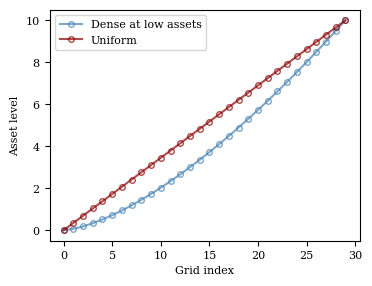

In [4]:
import matplotlib.pyplot as plt

# Common arguments controlling plot style
style = dict(marker='o', mfc='none', alpha=0.7, markersize=4)

plt.plot(grid_a, c='steelblue', label='Dense at low assets', **style)
plt.plot(grid_a_uniform, c='darkred', label='Uniform', **style)
plt.xlabel('Grid index')
plt.ylabel('Asset level')
plt.legend(loc='upper left')

#### Implementing VFI with grid search

The following code implements the VFI algorithm with grid search. We define
the function
```python
def vfi_grid(par, tol=1e-5, maxiter=1000):
    ...
```
which takes as arguments an instance of the `Parameters` class, the
termination tolerance `tol` and the maximum number of iterations `maxiter`. The function
creates a few arrays to hold the intermediate and final results and 
then iterates on the value function until convergence or until
the maximum number of iterations is exceeded.

Since the optimal savings choice has to lie on the asset grid, we represent the
savings policy function as an *integer* array which contains the *indices*
of the optimal asset level instead of the asset level itself.

In [5]:
def vfi_grid(par, tol=1e-5, maxiter=1000):
    
    N_a = len(par.grid_a)
    vfun = np.zeros(N_a)
    vfun_upd = np.empty(N_a)
    # index of optimal savings decision (stored in integer array!)
    pfun_ia = np.empty(N_a, dtype=np.uint)

    # pre-compute cash at hand for each asset grid point
    cah = (1 + par.r) * par.grid_a + par.y

    for it in range(maxiter):

        for ia, a in enumerate(par.grid_a):

            # find all values of a' that are feasible, ie. they satisfy
            # the budget constraint
            ia_to = np.where(par.grid_a <= cah[ia])[0]

            # consumption implied by choice a'
            #   c = (1+r)a + y - a'
            cons = cah[ia] - par.grid_a[ia_to]

            # Evaluate "instantaneous" utility
            if par.gamma == 1.0:
                u = np.log(cons)
            else:
                u = (cons**(1.0 - par.gamma) - 1.0) / (1.0 - par.gamma)

            # 'candidate' value for each choice a'
            v_cand = u + par.beta * vfun[ia_to]

            # find the 'candidate' a' which maximises utility
            ia_to_max = np.argmax(v_cand)

            # store results for next iteration
            v_opt = v_cand[ia_to_max]
            vfun_upd[ia] = v_opt
            pfun_ia[ia] = ia_to_max

        diff = np.max(np.abs(vfun - vfun_upd))

        # switch references to value functions for next iteration
        vfun, vfun_upd = vfun_upd, vfun

        if diff < tol:
            msg = f'VFI: Converged after {it:3d} iterations: dV={diff:4.2e}'
            print(msg)
            break
        elif it == 1 or it % 50 == 0:
            msg = f'VFI: Iteration {it:3d}, dV={diff:4.2e}'
            print(msg)
    else:
        msg = f'Did not converge in {it:d} iterations'
        print(msg)

    return vfun, pfun_ia

#### Running the solver

We are now ready to run the VFI. Note that the second return value is an
array of *indices* and hence we first need to recover the associated
asset levels to get proper savings policy function. The consumption policy
function can then be recovered from the budget constraint.

In [6]:
vfun, pfun_ia = vfi_grid(par)

# Recover savings policy function from optimal asset indices
pfun_a = par.grid_a[pfun_ia]

# Recover consumption policy function from budget constraint
cah = (1.0 + par.r) * par.grid_a + par.y
pfun_c = cah - pfun_a

VFI: Iteration   0, dV=2.43e+00
VFI: Iteration   1, dV=1.17e+00
VFI: Iteration  50, dV=8.31e-03
VFI: Iteration 100, dV=1.08e-03
VFI: Iteration 150, dV=1.40e-04
VFI: Iteration 200, dV=1.82e-05
VFI: Converged after 215 iterations: dV=9.87e-06


Finally, it i always a good idea to visualise the results to get some
economic intuition and spot errors.

Text(0.5, 0, 'Assets')

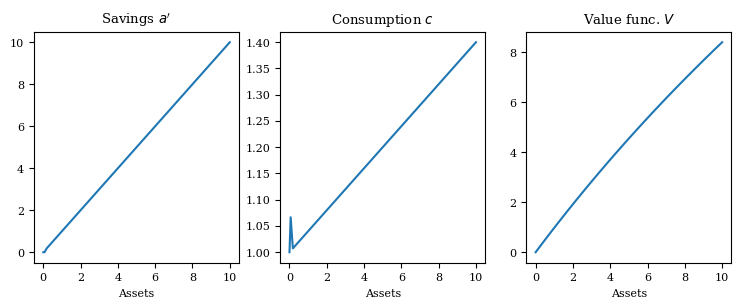

In [7]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(9, 3.0))

# Plot savings in first column
axes[0].plot(par.grid_a, pfun_a)
axes[0].set_title(r'Savings $a^{\prime}$')
axes[0].set_xlabel('Assets')

# Plot consumption in second column
axes[1].plot(par.grid_a, pfun_c)
axes[1].set_title(r'Consumption $c$')
axes[1].set_xlabel('Assets')

# Plot value function in third column
axes[2].plot(par.grid_a, vfun)
axes[2].set_title('Value func. $V$')
axes[2].set_xlabel('Assets')

The above plot suggests that there is a jump in the consumption policy function for low assets. There is no economic reason why this should be the case, and in fact this is an undesirable artifact of grid search. Such artifacts may appear for some choices of the asset grid, as is the case here. This is one of the reason why we usually prefer other solution methods that do not exhibit this behaviour, such as VFI with interpolation, which we turn to next.

### VFI with interpolation


In the previous section, we saw how grid search can give rise to undesired
numerical artifacts that misrepresent the solution. Moreover, unless
our grid is extremely dense, the solution is unlikely to satisfy the
first-order optimality conditions because the optimal
$a'$ need not be on the candidate grid. 

A more advanced solution method is to combine VFI with interpolation
of the continuation value paired with a maximisation step, which we 
explore in this section. The advantages of this method are

1. The solution is "exact" in a numerical sense.
2. It is less affected by the curse of dimensionality with many (continuous)
   choice variables.
3. It is easier to spot mistakes because the resulting policy functions
   tend to be smooth.

On the other hand, this method

1. Is likely to be slower than grid search; and
2. Is more complex to implement because we need an additional numerical
   maximisation routine which might require computing (numerical)
   derivatives.

#### Outline of the algorithm

To implement VFI with interpolation, we need to modify the original algorithm
as follows:

1. Create an asset grid $\Gamma_a = (a_1, \dots, a_{N_a})$.
2. Pick an initial guess $V_0$ for value function defined on $\Gamma_a$.
3. In iteration $n$, perform the following steps:

    For each asset level $a_i$ at grid point $i$,
      1. Compute the available resources (cash at hand):
         $$x_{i} = (1+r)a_i + y$$
      2. Find the maximiser 
         $$a^{\star} = \arg\max_{a' \in [0, x_{i}]} \Bigl\{ u\left(x_{i}-a'\right) + \beta V_n(a') \Bigr\}$$
         This step is usually performed using a numerical
         maximisation (or minimisation) routine.
      2. The value $V^{\star}$ is then given by
         $$V^{\star} = u\left(x_{ij}-a^{\star}\right) + \beta V_n(a^{\star})$$
      3. Store the updated value
         $V_{n+1,i} = V^{\star}$
         and the associated savings policy function.
4. Check for convergence: If $\|V_n-V_{n+1}\| < \epsilon$, 
  for some small tolerance $\epsilon > 0$, exit the algorithm.

Note that we still solve the problem on a grid $(a_1, \dots, a_{N_a})$
but we no longer require households to make savings choices exactly
on this grid.

#### Implementing VFI with interpolation

As before, the full implementation is provided in the Python script files
[`lectures/unit11/main.py`](../lectures/unit11/main.py) and 
[`lectures/unit11/VFI.py`](../lectures/unit11/VFI.py).

To perform the maximisation step, we need to define an objective function
that can be passed to a minimiser such as SciPy's
[`minimize_scalar()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html).
For the problem at hand, we define this objective function as 
```python
def f_objective(sav, cah, par, f_vfun):
    ...
```
where `sav` is the candidate savings level $a'$, `cah` is the
cash-at-hand at the current point $a_i$, `par` is the `Parameters` instance
and `f_vfun` is a callable function that can be used to evaluate
the continuation value $V_n(a')$ using interpolation. 
The implementation of this function looks as follows:

In [8]:
def f_objective(sav, cah, par, f_vfun):

    sav = float(sav)
    if sav < 0.0 or sav >= cah:
        return np.inf

    # Consumption implied by savings level
    cons = cah - sav

    # Continuation value interpolated onto asset grid
    vcont = f_vfun(sav)

    # evaluate "instantaneous" utility
    if par.gamma == 1.0:
        u = np.log(cons)
    else:
        u = (cons**(1.0 - par.gamma) - 1.0) / (1.0 - par.gamma)

    # Objective evaluated at current savings level
    obj = u + par.beta * vcont

    # We are running a minimiser, return negative of objective value
    return -obj

Because we are going to call this objective function from a minimiser, we need to return the negative utility as shown in the last line. 

Now that we have the objective function, VFI with interpolation is implemented by the following function:

In [9]:
from scipy.optimize import minimize_scalar

def vfi_interp(par, tol=1e-5, maxiter=1000):

    N_a = len(par.grid_a)
    vfun = np.zeros(N_a)
    vfun_upd = np.empty(N_a)
    # Optimal savings decision
    pfun_a = np.zeros(N_a)

    for it in range(maxiter):

        # Define function that interpolates continuation value
        f_vfun = lambda x: np.interp(x, par.grid_a, vfun)

        for ia, a in enumerate(par.grid_a):
            # Solve maximization problem at given asset level
            # Cash-at-hand at current asset level
            cah = (1.0 + par.r) * a + par.y
            # Restrict maximisation to following interval:
            bounds = (0.0, cah)
            # Arguments to be passed to objective function
            args = (cah, par, f_vfun)
            # perform maximisation
            res = minimize_scalar(f_objective, bracket=bounds, args=args)

            # Minimiser returns NEGATIVE utility, revert that
            vfun_upd[ia] = - res.fun
            # Store optimal savings a'
            pfun_a[ia] = res.x

        diff = np.max(np.abs(vfun - vfun_upd))

        # switch references to value functions for next iteration
        vfun, vfun_upd = vfun_upd, vfun

        if diff < tol:
            msg = f'VFI: Converged after {it:3d} iterations: dV={diff:4.2e}'
            print(msg)
            break
        elif it == 1 or it % 50 == 0:
            msg = f'VFI: Iteration {it:3d}, dV={diff:4.2e}'
            print(msg)
    else:
        msg = f'Did not converge in {it:d} iterations'
        print(msg)

    return vfun, pfun_a

#### Running the solver

We run the solver in the same way as we did with grid search, except that now
the function returns an array of optimal savings *levels*, not the
indices on the grid. We therefore no longer need to recover the
actual savings policy function.

In [10]:
vfun, pfun_a = vfi_interp(par)

# Recover consumption policy function from budget constraint
cah = (1.0 + par.r) * par.grid_a + par.y
pfun_c = cah - pfun_a

/home/lectures/.conda/envs/python-intro-PGR/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


VFI: Iteration   0, dV=2.43e+00
VFI: Iteration   1, dV=1.17e+00
VFI: Iteration  50, dV=6.39e-03
VFI: Iteration 100, dV=4.35e-04
VFI: Iteration 150, dV=2.96e-05
VFI: Converged after 170 iterations: dV=9.57e-06


Visualising the solution, we see that the artifacts in the consumption
policy function are no longer present.

Text(0.5, 0, 'Assets')

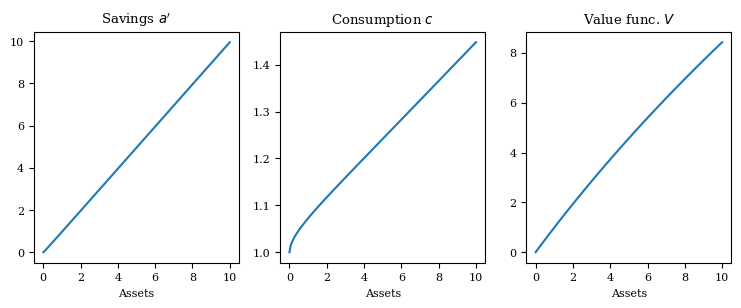

In [11]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(9, 3.0))

# Plot savings in first column
axes[0].plot(par.grid_a, pfun_a)
axes[0].set_title(r'Savings $a^{\prime}$')
axes[0].set_xlabel('Assets')

# Plot consumption in second column
axes[1].plot(par.grid_a, pfun_c)
axes[1].set_title(r'Consumption $c$')
axes[1].set_xlabel('Assets')

# Plot value function in third column
axes[2].plot(par.grid_a, vfun)
axes[2].set_title('Value func. $V$')
axes[2].set_xlabel('Assets')

***
## VFI with stochastic labour income

### Modelling stochastic labour income

So far, we assumed that labour income $y$ was deterministic and constant. In more realistic heterogeneous-agent models in macroeconomics and household finance, we instead model labour income as stochastic and thus risky. One frequent assumption is that labour income follows an AR(1) process in logs, i.e.,
$$
\begin{aligned}
    \log y_{t+1} &= \rho \log y_t + \nu_{t+1} \\
    \nu_{t+1} &\stackrel{\text{iid}}{\sim} N(0, \sigma^2)
\end{aligned}
$$
The corresponding household problem is then given by
$$
\begin{aligned}
V(y,a) = &\max_{c,\,a'}~\Bigl\{ u(c)
    + \beta \mathbb{E}\bigl[\left.V(y',a')~\right|~ y\bigr] \Bigr\} \\
    \text{s.t.} \quad &c + a' = (1+r)a  + y \\
    & c \geq 0,\; a' \geq 0
\end{aligned}
$$
where we added the additional state variable $y$ and need to take expectations over future realisations of $y'$.

There are two commonly-used approaches to incorporate such an income process into our household problem:

1. Assume that $y$ is a continuous state variable and use [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature) to compute expectations.
2. Discretize $y$ to take on a few selected values and model it as a Markov chain on the discretised state space.

We will following the second approach in this unit. Two common algorithms to "convert" an AR(1) into a Markov chain are the Tauchen and the Rouwenhorst methods. The latter seems to be preferable when dealing with highly persistent processes such as labour income. The discretised labour income process with $N_y$ grid points is then given by the states $\Gamma_y = (y_1,\dots,y_{N_y})$ and the transition matrix $\Pi_y$ with typical element
$$
\Pi_y(i,j) = \text{Pr}\bigl[y_{t+1} = y_j~|~y_t = y_i\bigr]~.
$$

We use the function `rouwenhorst()` defined below to perform this mapping for us. Its arguments are the number of nodes of the discretized state space `n`, the mean of the AR(1) process `mu`, the autocorrelation parameter `rho` and the conditional standard deviation `sigma`
(see the file [`lectures/unit11/markov.py`](../lectures/unit11/markov.py) for a complete implementation which includes error checking of input arguments). There is no need to understand the details of this function as we are only interested in using its return values: the state space stored in the vector `z` and the transition matrix `Pi`. 

In [12]:
import numpy as np

def rouwenhorst(n, mu, rho, sigma):
    
    p = (1+rho)/2
    Pi = np.array([[p, 1-p], [1-p, p]])

    for i in range(Pi.shape[0], n):
        tmp = np.pad(Pi, 1, mode='constant', constant_values=0)
        Pi = p * tmp[1:, 1:] + (1-p) * tmp[1:, :-1] + \
             (1-p) * tmp[:-1, 1:] + p * tmp[:-1, :-1]
        Pi[1:-1, :] /= 2

    fi = np.sqrt(n-1) * sigma / np.sqrt(1 - rho ** 2)
    z = np.linspace(-fi, fi, n) + mu

    return z, Pi

#### Model parameters

Since the household problem with stochastic labour income has a few more parameters, we redefine the `Parameters` class from earlier to include these. The additional parameters
are listed in the table below. The values for the AR(1) labour income process
are standard and taken from papers such as Aiyagari (1994).

| Parameter | Description | Value |
|-----------|-------------|-------|
| $\beta$ | Discount factor | 0.96 |
| $\gamma$ | Coef. of relative risk aversion | 2 |
| $r$ | Interest rate | 0.04 |
| $\rho$| Autocorrelation of labour income | 0.95 |
| $\sigma$| Conditional std. dev. of labour income | 0.20|
| $N_y$ | Number of states for Markov chain | 3 |

The updated definition of `Parameters` now looks as follows:

In [13]:
@dataclass
class Parameters:
    """
    Define object to store model parameters and their default values
    """
    beta = 0.96         # Discount factor
    gamma = 1.0         # Risk aversion
    r = 0.04            # Interest rate
    rho = 0.95          # Autocorrelation of log labour income
    sigma = 0.20        # Conditional standard deviation of log labour income
    grid_a = None       # Asset grid (to be created)
    grid_y = None       # Discretised labour income grid (to be created)
    tm_y = None         # Labour transition matrix (to be created)

We can use the above function to create a discretised representation of the risky labour income. For illustrative purposes we choose to discretise $y$ to only three points which would be considered too few for realistic models.

In [14]:
par = Parameters()

# Number of labour grid points
N_y = 3

# Discretise labour income process (assume zero mean in logs)
states, tm_y = rouwenhorst(N_y, mu=0.0, rho=par.rho, sigma=par.sigma)

# State space in levels
grid_y = np.exp(states)

# Store labour grid and transition matrix
par.grid_y = grid_y
par.tm_y = tm_y

Note that because stochastic income is log-normal and has zero mean in logs, due to the properties of the log-normal distribution the average income in *levels* in the cross-section of households is given by
$$
\mathbb{E}[y] = \exp\left(\frac{1}{2}\sigma_{\nu}^2\right) > 1 
$$
This is often undesirable as we'd like to normalise average income in the economy to unity since this makes interpreting magnitudes easier. We can achieve this by computing the ergodic (stationary) distribution of labour using the following 
function (see also [`lectures/unit11/markov.py`](../lectures/unit11/markov.py) for a complete implementation).
Again, there is no need to understand what this function does, we are only interested
in the stationary distribution it returns in the vector `mu`.

In [15]:
import numpy.linalg

def markov_ergodic_dist(transm):
    transm = transm.transpose()
    m = transm - np.identity(transm.shape[0])
    m[-1] = 1
    m = np.linalg.inv(m)
    mu = np.ascontiguousarray(m[:, -1])
    assert np.abs(np.sum(mu) - 1) < 1e-9
    mu /= np.sum(mu)
    return mu

We use this function to compute the ergodic distribution `edist` implied by the Markov chain transition matrix. We can then use this distribution to compute expectation $\mathbb{E}[y]$ and we normalise the state space by this value.

In [16]:
# Ergodic distribution of labour income
edist = markov_ergodic_dist(tm_y)

# Non-normalised mean of labour income
mean = np.dot(edist, par.grid_y)

# Normalise states such that unconditional expectation is 1.0
par.grid_y /= mean

Finally, we complete the setup of the problem by re-creating the asset grid in the same way we did above.

In [17]:
# Start + end point for asset grid
a_min = 0.0
a_max = 10.0
# Number of grid points
N_a = 30

# Create asset grid with more points at the beginning
grid_a  = a_min + (a_max - a_min) * np.linspace(0.0, 1.0, N_a)**1.5

# Store asset grid in Parameters object
par.grid_a = grid_a

### VFI with grid search

Before turning to the actual implementation, it is instructive to look at the modified grid search algorithm for the case of risky labour income. The main difference is that we now have an additional state variable $y$ and need to take care of expectations.

#### Outline of the algorithm

1. Create an asset grid $\Gamma_a = (a_1, \dots, a_{N_a})$.
2. Create a discretised labour income process with 
   states $\Gamma_y = (y_1, \dots, y_{N_y})$ and transition matrix
   $\Pi_y$.
3. Pick an initial guess $V_0$ for the value function defined 
   on $\Gamma_y \times \Gamma_a$.
4. In iteration $n$, perform the following steps:

    For each labour income $y_i$ at index $i$,

    1. Compute the expectation over labour income realisations $y'$ given
      $y_i$, $$ \widetilde{V}(a') = \mathbb{E}\bigl[V_n(y',a')~|~y_i \bigr]$$
      using the $i$-th row of the transition matrix $\Pi_y$.
    2. For each asset level $a_j$ at grid point $j$,
        1. Find all feasible next-period
           asset levels $a_k \in \Gamma_a$ that satisfy the
           budget constraint 
           $$a_k \leq (1+r)a_j + y_i$$
         2. For each $k$, compute consumption 
            $$c_{k} = (1+r)a_j + y_i - a_k$$
         3. For each $k$, compute utility 
            $$U_k = u(c_k) + \beta \widetilde{V}(a_k)$$
         4. Find the index $\ell$ that maximises the above expression:
            $$\ell = \arg\max_{k} \Bigl\{ u(c_k) + \beta \widetilde{V}(a_k)\Bigr\}$$
         5. Set $V_{n+1,ij} = U_\ell$ and store $\ell$ as the optimal choice at $(i,j)$
5. Check for convergence: If $\|V_n-V_{n+1}\| < \epsilon$, 
  for some small tolerance $\epsilon > 0$, exit the algorithm.

#### Implementing VFI with grid search

The following code implements VFI with risky labour income using grid search (the code can also be found in 
[`lectures/unit11/VFI_risk.py`](../lectures/unit11/VFI_risk.py)).

In [18]:
def vfi_grid(par, tol=1e-5, maxiter=1000):
    
    N_a, N_y = len(par.grid_a), len(par.grid_y)
    shape = (N_y, N_a)
    vfun = np.zeros(shape)
    vfun_upd = np.empty(shape)
    # index of optimal savings decision
    pfun_ia = np.empty(shape, dtype=np.uint)

    # pre-compute cash at hand for each (asset, labour) grid point
    cah = (1 + par.r) * par.grid_a[None] + par.grid_y[:,None]

    for it in range(maxiter):

        # Compute expected continuation value E[V(y',a')|y] for each (y,a')
        EV = np.dot(par.tm_y, vfun)

        for iy in range(N_y):
            for ia, a in enumerate(par.grid_a):

                # find all values of a' that are feasible, ie. they satisfy
                # the budget constraint
                ia_to = np.where(par.grid_a <= cah[iy, ia])[0]

                # consumption implied by choice a'
                #   c = (1+r)a + y - a'
                cons = cah[iy, ia] - par.grid_a[ia_to]

                # Evaluate "instantaneous" utility
                if par.gamma == 1.0:
                    u = np.log(cons)
                else:
                    u = (cons**(1.0 - par.gamma) - 1.0) / (1.0 - par.gamma)

                # 'candidate' value for each choice a'
                v_cand = u + par.beta * EV[iy, ia_to]

                # find the 'candidate' a' which maximizes utility
                ia_to_max = np.argmax(v_cand)

                # store results for next iteration
                v_opt = v_cand[ia_to_max]
                vfun_upd[iy, ia] = v_opt
                pfun_ia[iy, ia] = ia_to_max

        diff = np.max(np.abs(vfun - vfun_upd))

        # switch references to value functions for next iteration
        vfun, vfun_upd = vfun_upd, vfun

        if diff < tol:
            msg = f'VFI: Converged after {it:3d} iterations: dV={diff:4.2e}'
            print(msg)
            break
        elif it == 1 or it % 50 == 0:
            msg = f'VFI: Iteration {it:3d}, dV={diff:4.2e}'
            print(msg)
    else:
        msg = f'Did not converge in {it:d} iterations'
        print(msg)

    return vfun, pfun_ia

We can now run and plot the solution as we did in the case of deterministic income.

In [19]:
vfun, pfun_ia = vfi_grid(par)

# Recover savings policy function from optimal asset indices
pfun_a = par.grid_a[pfun_ia]

# Recover consumption policy function from budget constraint
cah = (1.0 + par.r) * par.grid_a + par.grid_y[:, None]
pfun_c = cah - pfun_a

VFI: Iteration   0, dV=2.52e+00
VFI: Iteration   1, dV=1.38e+00
VFI: Iteration  50, dV=3.02e-02
VFI: Iteration 100, dV=2.07e-03
VFI: Iteration 150, dV=2.29e-04
VFI: Iteration 200, dV=2.87e-05
VFI: Converged after 226 iterations: dV=9.88e-06


Finally, we plot the solution for all levels of labour income. Note that we need to transpose the result arrays because Matplotlib's `plot()` expects input arrays to have the same number of elements along the first dimension.

Text(0.5, 0, 'Assets')

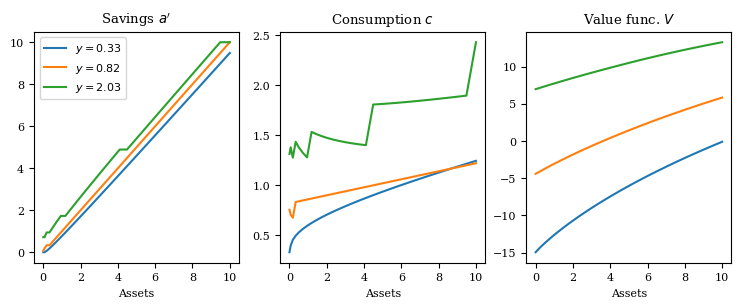

In [20]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(9, 3.0))

# Plot savings in first column
axes[0].plot(par.grid_a, pfun_a.T)
axes[0].set_title(r'Savings $a^{\prime}$')
axes[0].set_xlabel('Assets')
# Insert legend
labels = [f'$y={y:.2f}$' for y in par.grid_y]
axes[0].legend(labels, loc='upper left')

# Plot consumption in second column
axes[1].plot(par.grid_a, pfun_c.T)
axes[1].set_title(r'Consumption $c$')
axes[1].set_xlabel('Assets')

# Plot value function in third column
axes[2].plot(par.grid_a, vfun.T)
axes[2].set_title('Value func. $V$')
axes[2].set_xlabel('Assets')



With stochastic labour income, the numerical artifacts produced by grid search are even more pronounced which speaks against using this method for this type of problem, if possible.

### VFI with interpolation

We can adjust the interpolation algorithm to deal with stochastic labour income
in the same way as we augmented the grid search.

#### Outline of the algorithm

To implement VFI with interpolation, we need to modify the original algorithm
as follows:

1. Create an asset grid $\Gamma_a = (a_1, \dots, a_{N_a})$.
2. Create a discretised labour income process with 
   states $\Gamma_y = (y_1, \dots, y_{N_y})$ and transition matrix
   $\Pi_y$.
3. Pick an initial guess $V_0$ for value function defined
   on $\Gamma_y \times \Gamma_a$.
4. In iteration $n$, perform the following steps:

   For each labour income $y_i$ at index $i$,

   1. Compute the expectation over labour income realisations $y'$ given
      $y_i$, $$ \widetilde{V}(a') = \mathbb{E}\bigl[V_n(y',a')~|~y_i \bigr]$$
      using the $i$-th row of the transition matrix $\Pi_y$.
   2. For each asset level $a_j$ at grid point $j$,
      1. Compute the available resources (cash at hand):
         $$x_{ij} = (1+r)a_i + y_i$$
      2. Find the maximiser 
         $$a^{\star} = \arg\max_{a' \in [0, x_{ij}]} \Bigl\{ u\left(x_{ij}-a'\right) + \beta \widetilde{V}(a') \Bigr\}$$
         This step is usually performed using a numerical
         maximisation (or minimisation) routine.
      2. The value $V^{\star}$ is then given by
         $$V^{\star} = u\left(x_{ij}-a^{\star}\right) + \beta \widetilde{V}(a^{\star})$$
      3. Store the updated value
         $V_{n+1,ij} = V^{\star}$
         and the associated savings policy function.
5. Check for convergence: If $\|V_n-V_{n+1}\| < \epsilon$, 
  for some small tolerance $\epsilon > 0$, exit the algorithm.


#### Implementing VFI with interpolation

The following code implements VFI with risky labour income using interpolation (the code can also be found in 
[`lectures/unit11/VFI_risk.py`](../lectures/unit11/VFI_risk.py)).

Note that the objective function `f_objective()` remains unchanged from before
because we adapted the argument `f_vfun` to interpolate over the pre-computed
expected value of $\widetilde{V}(a')$ instead of $V_n(a')$ as in the original implementation.

In [21]:
def vfi_interp(par, tol=1e-5, maxiter=1000):

    N_a, N_y = len(par.grid_a), len(par.grid_y)
    shape = (N_y, N_a)
    vfun = np.zeros(shape)
    vfun_upd = np.empty(shape)
    # Optimal savings decision
    pfun_a = np.zeros(shape)

    for it in range(maxiter):

        # Compute expected continuation value E[V(y',a')|y] for each (y,a')
        EV = np.dot(par.tm_y, vfun)

        for iy, y in enumerate(par.grid_y):

            # function to interpolate continuation value
            f_vfun = lambda x: np.interp(x, par.grid_a, EV[iy])

            for ia, a in enumerate(par.grid_a):
                # Solve maximization problem at given asset level
                # Cash-at-hand at current asset level
                cah = (1.0 + par.r) * a + y
                # Restrict maximisation to following interval:
                bounds = (0.0, cah)
                # Arguments to be passed to objective function
                args = (cah, par, f_vfun)
                # perform maximisation
                res = minimize_scalar(f_objective, bracket=bounds, args=args)

                # Minimiser returns NEGATIVE utility, revert that
                v_opt = - res.fun
                sav_opt = float(res.x)

                vfun_upd[iy, ia] = v_opt
                pfun_a[iy, ia] = sav_opt

        diff = np.max(np.abs(vfun - vfun_upd))

        # switch references to value functions for next iteration
        vfun, vfun_upd = vfun_upd, vfun

        if diff < tol:
            msg = f'VFI: Converged after {it:3d} iterations: dV={diff:4.2e}'
            print(msg)
            break
        elif it == 1 or it % 50 == 0:
            msg = f'VFI: Iteration {it:3d}, dV={diff:4.2e}'
            print(msg)
    else:
        msg = f'Did not converge in {it:d} iterations'
        print(msg)

    return vfun, pfun_a

The following code is used to perform the VFI. Note that once as in the deterministic setting, the savings policy function returns savings *levels*, even though now all return values are 2-dimensional arrays.

In [22]:
vfun, pfun_a = vfi_interp(par)

# Recover consumption policy function from budget constraint
cah = (1.0 + par.r) * par.grid_a + par.grid_y[:, None]
pfun_c = cah - pfun_a

/home/lectures/.conda/envs/python-intro-PGR/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


VFI: Iteration   0, dV=2.52e+00
VFI: Iteration   1, dV=1.38e+00
VFI: Iteration  50, dV=2.95e-02
VFI: Iteration 100, dV=1.95e-03
VFI: Iteration 150, dV=2.16e-04
VFI: Iteration 200, dV=2.73e-05
VFI: Converged after 225 iterations: dV=9.80e-06


We use the same code as above to visualise the results:

Text(0.5, 0, 'Assets')

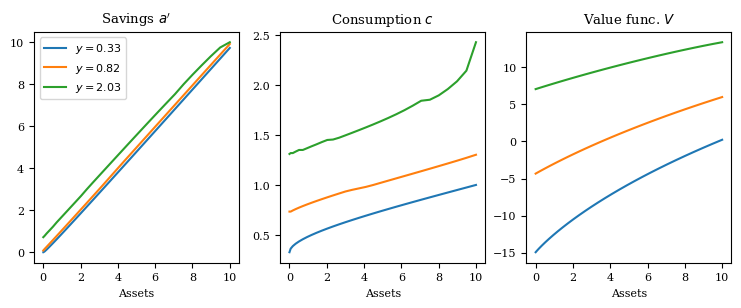

In [23]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(9, 3.0))

# Plot savings in first column
axes[0].plot(par.grid_a, pfun_a.T)
axes[0].set_title(r'Savings $a^{\prime}$')
axes[0].set_xlabel('Assets')
# Insert legend
labels = [f'$y={y:.2f}$' for y in par.grid_y]
axes[0].legend(labels, loc='upper left')

# Plot consumption in second column
axes[1].plot(par.grid_a, pfun_c.T)
axes[1].set_title(r'Consumption $c$')
axes[1].set_xlabel('Assets')

# Plot value function in third column
axes[2].plot(par.grid_a, vfun.T)
axes[2].set_title('Value func. $V$')
axes[2].set_xlabel('Assets')


The policy functions are much smoother compared to those produced by grid search. However, as you can see there is another artifact of our numerical implementation that did not stand out as much earlier: the consumption policy for the highest labour state is suspiciously upward-sloping towards the end!
This is a consequence of not permitting extrapolation of the continuation value, and hence any savings that would take the household beyond the grid upper bound are wasted. It is therefore optimal to consume all such "excess" savings, which gives rise to the increase in consumption at the right end of the asset grid.
We could address this problem by allowing extrapolation, but linear extrapolation of value functions is undesirable for other reasons.